## Epipolar geometry
set up two cameras, both with the internal parameters,
$$
K = \begin{bmatrix}
1000 & 0 & 300 \\ 0 & 1000 & 200 \\ 0 & 0 & 1
\end{bmatrix}
$$
Now, for the first camera — let us call that Cam1 — set the rotation to identity $R1 = I$ and set the translation to zero $t1 = 0$. For the second camera $Cam2$ use the rotation given by the $R$ function
$$
R_2 = R(0.7,-0.5,0.8) \\
R(\theta_x, \theta_y, \theta_z) = \begin{bmatrix}
cos(\theta_z) & -sin(\theta_z) & 0 \\ sin(\theta_z) & cos(\theta_z) & 0 \\ 0 & 0 & 1
\end{bmatrix}  \begin{bmatrix}
cos(\theta_y) & 0 & sin(\theta_y) \\ 0 & 0 & 1 \\ -sin(\theta_y) & 0 & cos(\theta_y)
\end{bmatrix} \begin{bmatrix}
1 & 0 & 0\\ 0 & cos(\theta_x) & -sin(\theta_x) \\ 0 & sin(\theta_x) & cos(\theta_x)
\end{bmatrix}
$$
and the translation
$$
t_2 = \begin{bmatrix} 0.2 \\ 2 \\ 1 \end{bmatrix}.
$$

The rotation can be constructed in Python using Rotation module from scipy as follows:
```
from scipy.spatial.transform import Rotation
R2 = Rotation.from_euler('xyz', [0.7, -0.5, 0.8]).as_matrix()
```

### Exercise 3.1
Consider the 3D point
$$
Q = \begin{bmatrix} 1 \\ 0.5 \\ 4 \\ 1 \end{bmatrix}
$$
and find the projections in $Cam1$ and $Cam2$, respectively, points $q1$ and $q2$.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation

# converts from homogeneous to inhomogeneous coordinates
def Pi(ph):
    return ph[:-1]/ph[-1]
    
# converts from inhomogeneous to homogeneous coordinates
def PiInv(p):
    ones = np.ones((1, p.shape[1]))
    ph = np.vstack((p, ones))
    return ph

def projectpoints(K, R, t, Q):
    Q_homogeneous = PiInv(Q)
    q = np.hstack((R,t)) @ Q_homogeneous
    P = Pi(q)
    p = K @ PiInv(P)
    return p

K = np.array([[1000,0,300],[0,1000,200],[0,0,1]])
R1 = np.eye(3)
R2 = Rotation.from_euler('xyz', [0.7, -0.5, 0.8]).as_matrix()
t1 = np.zeros((3,1))
t2 = np.array([[0.2,2,1]]).T
Q = np.array([[1,0.5,4,1]]).T

q1 = projectpoints(K, R1, t1, Pi(Q))
q2 = projectpoints(K, R2, t2, Pi(Q))

print('q1 = \n', Pi(q1))
print('q2 = \n', Pi(q2).round(3))

q1 = 
 [[550.]
 [325.]]
q2 = 
 [[582.473]
 [185.99 ]]


### Exercise 3.2
Implement a function CrossOp that takes a vector in 3D and returns the 3×3 matrix corresponding to taking the cross product with that vector. In the case that $p = \begin{bmatrix} x & y & z \end{bmatrix}^T $ you should have
$$
CrossOp(p) = [p]_\times = \begin{bmatrix} 0 & -z & y \\ z & 0 & -x \\ -y & 0 & x \end{bmatrix}
$$
As a good habit, verify that your function works by testing it on random vectors to ensure that
$$
[p_1]_\times p_2 = p_1 \times p_2
$$

In [2]:
def CrossOp(p):
    p = np.array(p).flatten()
    return np.array([[0, -p[2], p[1]],
                     [p[2], 0, -p[0]],
                     [-p[1], p[0], 0]])

p1 = np.random.rand(3)
p2 = np.random.rand(3)
print("[p1]xp2 = ", CrossOp(p1) @ p2)
print("p1 x p2 = ", np.cross(p1,p2))

[p1]xp2 =  [-0.03390529 -0.41704744  0.32242551]
p1 x p2 =  [-0.03390529 -0.41704744  0.32242551]


### Exercise 3.3
Compute the fundamental matrix $F$ of the two cameras.

In [3]:
# Calculate essential matrix E
E = CrossOp(t2) @ R2
# Calculate fundamental matrix F
F = np.linalg.inv(K).T @ E @ np.linalg.inv(K)
print(F)

[[ 3.29311881e-07  8.19396327e-07  1.79162592e-03]
 [ 5.15532551e-07 -8.76915984e-07  9.31426656e-05]
 [-1.29882755e-03  1.51951700e-03 -1.10072682e+00]]


### Exercise 3.4
What is the epipolar line $l$ of $q_1$ in camera two?

In [4]:
l_q1 = F @ q1
print(l_q1)

[[ 2.23905126e-03]
 [ 9.16878739e-05]
 [-1.32123895e+00]]


### Exercise 3.5
Is $q_2$ located on the epipolar line from Exercise 3.4? Do the computations, but also explain why this must be so.

In [5]:
print((q2.T@l_q1)[0][0])

4.440892098500626e-16


> This prints -4.44089209850063e-16, which is very close to zero, indicating that $q_2$ is indeed located on the epipolar line.

>This is expected, because $q_1$ and $q_2$ correspond to the same 3D point in the scene, and their projections onto the two image planes must be related by the epipolar geometry. In particular, the epipolar line corresponding to $q_1$ must pass through the projection of $q_2$ in the second image, and vice versa. Therefore, $q_2$ must lie on the epipolar line corresponding to $q_1$.

### Exercise 3.6
Now assume that both camera one and two have local coordinate systems that are different from the coordinate system of the world.

Let $Q$ and $\tilde{Q}$ denote the same 3D point in world space and in the frame of camera one. In other
words we have relation
$$
\tilde{Q} = \begin{bmatrix} R_1 & t_1 \\ 0 & 1 \end{bmatrix} Q
$$
Make sure you understand why this is true.

Show analytically that 
$$
Q = \begin{bmatrix} R_1^T & - R_1^T t_1 \\ 0 & 1 \end{bmatrix} \tilde{Q}
$$

---
$$ 
\tilde{Q} = \begin{bmatrix} R_1 & t_1 \\ 0 & 1 \end{bmatrix} \begin{bmatrix} R_1^T & - R_1^T t_1 \\ 0 & 1 \end{bmatrix} \tilde{Q}
$$
$$
\tilde{Q} = \begin{bmatrix} R_1 R_1^T & -R_1 R_1^T t_1 + t_1 \\ 0 & 1 \end{bmatrix} \tilde{Q} \\ 
$$
$$
\tilde{Q} = \begin{bmatrix} I & 0 \\ 0 & 1 \end{bmatrix} \tilde{Q} . 
$$ 

> And we find that it is valid! This is true as the matrices are inverses of each other.

### Exercise 3.7
Show that the projection can work only in the coordinate system of camera one, by showing that we can project points with
$$
q_1 = K \begin{bmatrix} I & 0 \end{bmatrix} \tilde{Q}
$$
$$
q_2 = K \begin{bmatrix} \tilde{R}_2 & \tilde{t}_2 \end{bmatrix} \tilde{Q} 
$$
where 
$$
\tilde{R}_2 = R_2 R_1^T, \tilde{t}_2 = t_2 - R_2 R_1^T t_1 .
$$

> For the first projection in camera one we reduce the projection equation: $$ q_1 = K[R_1 | t_1] Q = K\begin{bmatrix} I & 0 \end{bmatrix} \begin{bmatrix} R_1 & t_1 \\ 0 & 1 \end{bmatrix} Q = K \begin{bmatrix} I & 0 \end{bmatrix} \tilde{Q} $$
> For the second projection into camera two we insert Equation 14: $$ q_2 = K[R_2 | t_2]Q = K[R_2 | t_2] \begin{bmatrix} R_1^T & - R_1^T t_1 \\ 0 & 1 \end{bmatrix} = K \begin{bmatrix} R_2 R_1^T & t_2 - \tilde{R}_2 t_1 \end{bmatrix} \tilde{Q} = K \begin{bmatrix} \tilde{R}_2 & \tilde{t}_2 \end{bmatrix} \tilde{Q} $$

## Applied epipolar geometry
### Exercise 3.8
Load the file TwoImageData.npy, and compute the fundamental matrix between camera one and two. \
$Tip$: You can load the file with:
```
np.load('TwoImageData.npy', allow_pickle=True).item()
```

In [6]:
TwoImageData = np.load('TwoImageData.npy', allow_pickle=True).item()
im1 = TwoImageData['im1']
im2 = TwoImageData['im2']
R1 = TwoImageData['R1']
R2 = TwoImageData['R2']
t1 = TwoImageData['t1']
t2 = TwoImageData['t2']
K = TwoImageData['K']

E = CrossOp(t2) @ R2
F = np.linalg.inv(K).T @ E @ np.linalg.inv(K)
print(F)

[[ 6.67972386e-12 -7.85049967e-10  1.17921973e-07]
 [-9.75936980e-10 -4.86806510e-12  3.28699196e-05]
 [ 4.23506610e-07 -3.21704080e-05 -2.12002228e-04]]


### Exercise 3.9
Write code that can show both images at the same time. Now write code such that you can click on a point in image one, and display the corresponding epipolar line in image two. Experiment with your code, verifying that the point you click on is on the epipolar line in the other image.

$Tip$: To click on a point and get the pixel coordinates you can use plt.ginput(1). If you are using Jupyter notebook you might need to run %matplotlib qt first

$Tip$: To draw a line given in homogeneous coordinates, you can use the DrawLine function below.\
It takes as input a line in homogeneous coordinates l and the size of the image it will be drawn on, as returned by im.shape.
```
def DrawLine(l, shape):
    #Checks where the line intersects the four sides of the image
    # and finds the two intersections that are within the frame
    def in_frame(l_im):
        q = np.cross(l.flatten(), l_im)
        q = q[:2]/q[2]
        if all(q>=0) and all(q+1<=shape[1::-1]):
            return q
    lines = [[1, 0, 0], [0, 1, 0], [1, 0, 1-shape[1]], [0, 1, 1-shape[0]]]
    P = [in_frame(l_im) for l_im in lines if in_frame(l_im) is not None]
    plt.plot(*np.array(P).T)
```

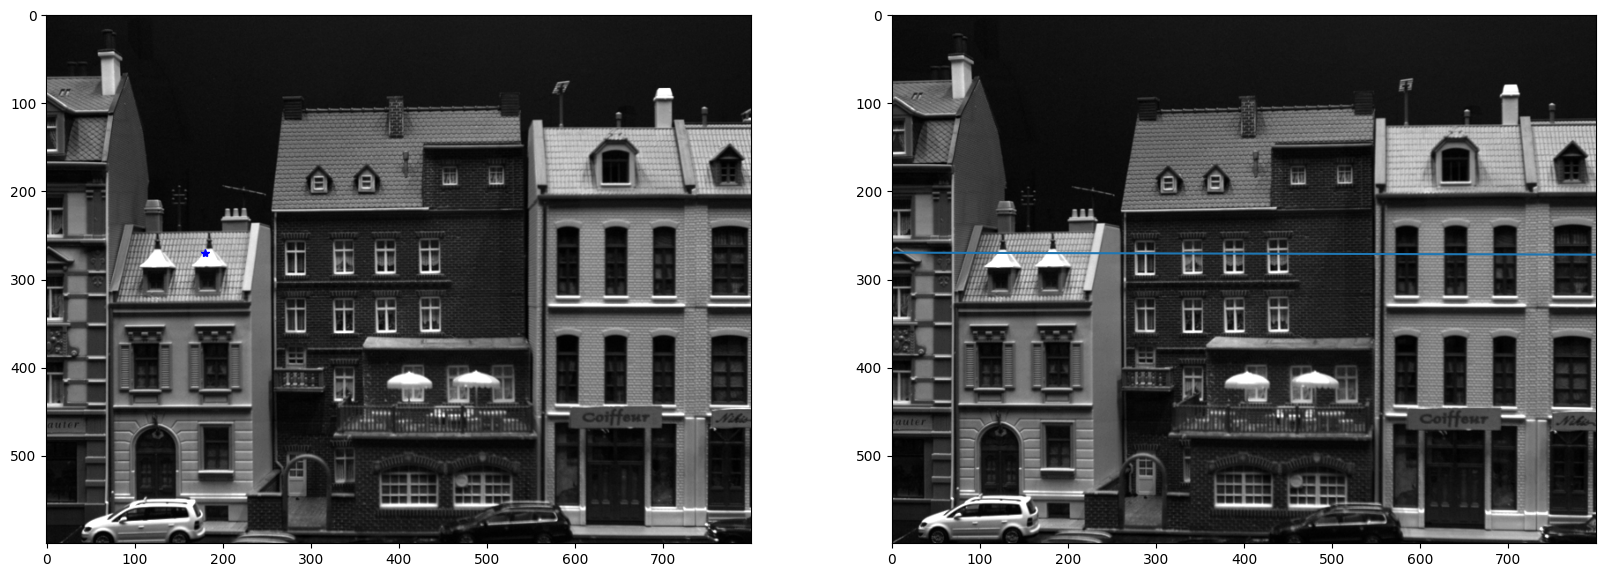

In [7]:
def DrawLine(l, shape):
    #Checks where the line intersects the four sides of the image
    # and finds the two intersections that are within the frame
    def in_frame(l_im):
        q = np.cross(l.flatten(), l_im)
        q = q[:2]/q[2]
        if all(q>=0) and all(q+1<=shape[1::-1]):
            return q
    lines = [[1, 0, 0], [0, 1, 0], [1, 0, 1-shape[1]], [0, 1, 1-shape[0]]]
    P = [in_frame(l_im) for l_im in lines if in_frame(l_im) is not None]
    plt.plot(*np.array(P).T)

def click_epipolar(image1, image2, F):
    %matplotlib qt
    plt.imshow(image1)
    click_point = plt.ginput(1)
    p1 = np.array(click_point).reshape(2,1)
    l_p1 = F @ PiInv(p1)
    return p1, l_p1

def draw_epipolar(im1, im2, p1, l_p1):
    %matplotlib inline
    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
    plt.imshow(im1,cmap='gray')
    plt.plot(p1[0],p1[1],'b*')
    plt.subplot(1,2,2)
    plt.imshow(im2,cmap='gray')
    DrawLine(l_p1,im2.shape)

p1, l_p1 = click_epipolar(im1, im2, F)
draw_epipolar(im1, im2, p1, l_p1)

### Exercise 3.10
Do the same thing as the last exercise, but where you can click in image two and get the epipolar
line displayed in image one.


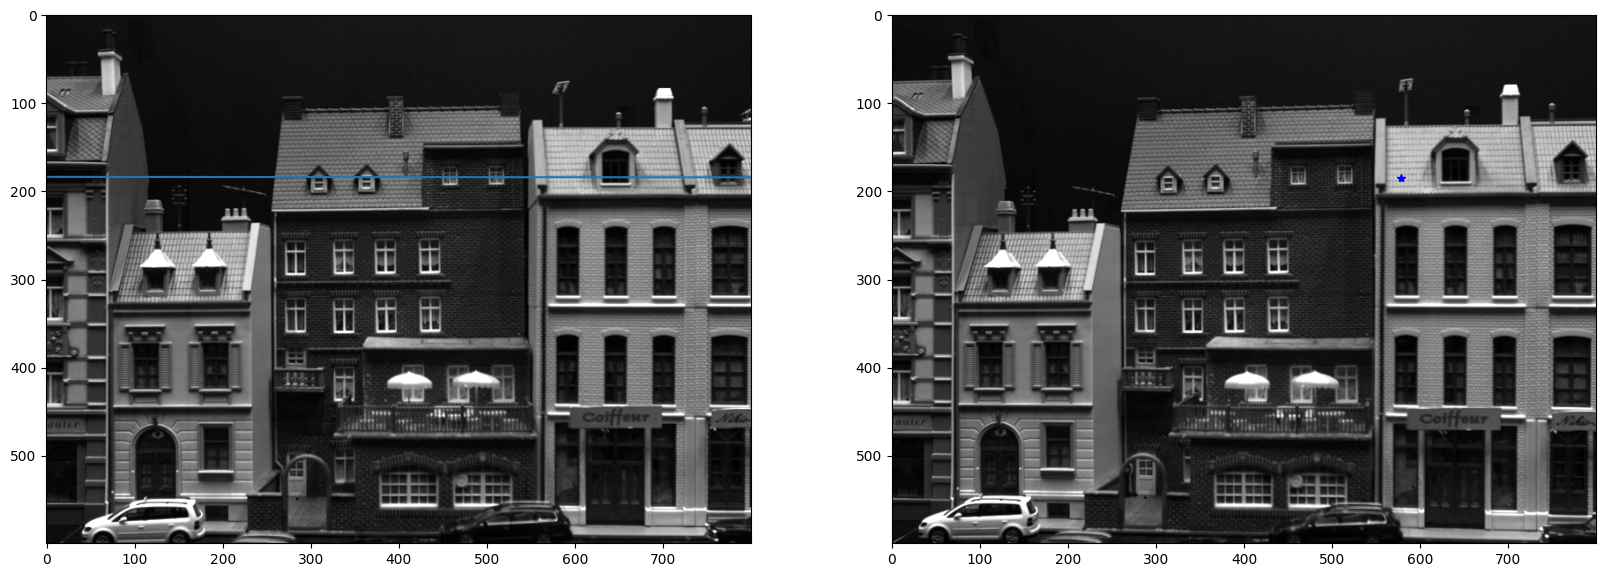

In [8]:
def draw_epipolar(im1, im2, p1, l_p1):
    %matplotlib inline
    plt.figure(figsize=(20,20))
    plt.subplot(1,2,2)
    plt.imshow(im1,cmap='gray')
    plt.plot(p1[0],p1[1],'b*')
    plt.subplot(1,2,1)
    plt.imshow(im2,cmap='gray')
    DrawLine(l_p1,im2.shape)

p2, l_p2 = click_epipolar(im2, im1, F)
draw_epipolar(im2, im1, p2, l_p2)

### Exercise 3.11
Create a function triangulate. It should be able to triangulate a single 3D point that has been seen by n different cameras. The function should take as input: a list of n pixel coordinates (q1, q2, . . . , qn), and a list of n projection matrices (P1, P2, . . . , Pn), and should return the triangulation of the point in 3D using the linear algorithm. \
Test your function by defining a 3D point, project this point to the image planes of the two cameras, and then triangulate it using the projection. Try reprojecting your estimated 3D point to the cameras. Do you find the same 2D pixels?

In [9]:
import numpy as np

def triangulate(q_list, P_list):
    A = np.zeros((2*len(q_list), 4))
    for i in range(len(q_list)):
        A[2*i, :] = q_list[i][0]*P_list[i][2,:] - P_list[i][0,:]
        A[2*i+1, :] = q_list[i][1]*P_list[i][2,:] - P_list[i][1,:]
    _, _, V = np.linalg.svd(A)
    X = V[-1,:-1] / V[-1,-1]
    return X


In [10]:
# Define the 3D point
X = np.array([1.0, 2.0, 3.0])

# Define intrinsic parameters for the two cameras
K = np.array([[1000, 0, 320], [0, 1000, 240], [0, 0, 1]])

# Define extrinsic parameters for the first camera
R1 = np.eye(3)
t1 = np.array([0, 0, 0])
P1 = K @ np.hstack((R1, -t1.reshape(3, 1)))

# Define extrinsic parameters for the second camera
R2 = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
t2 = np.array([1, 0, 0])
P2 = K @ np.hstack((R2, -t2.reshape(3, 1)))

# Project the 3D point to the image planes of the two cameras
q1 = K @ (R1 @ X + t1)
q1 /= q1[2]
q2 = K @ (R2 @ X + t2)
q2 /= q2[2]

# Triangulate the 3D point from the two image points and projection matrices
X_est = triangulate([q1[:2], q2[:2]], [P1, P2])

# Reproject the estimated 3D point to the image planes of the two cameras
q1_est = K @ (np.hstack((R1, -t1.reshape(3, 1))) @ np.hstack((X_est, 1)).reshape(4, 1))
q1_est /= q1_est[2]
q2_est = K @ (np.hstack((R2, -t2.reshape(3, 1))) @ np.hstack((X_est, 1)).reshape(4, 1))
q2_est /= q2_est[2]

# Check if we get the same 2D pixels
print("q1 == q1_est:", np.allclose(q1[:2].reshape(1,2), q1_est[:2].reshape(1,2), rtol=1e-03, atol=1e-03))
print("q2 == q2_est:", np.allclose(q2[:2].reshape(1,2), q2_est[:2].reshape(1,2), rtol=1e-03, atol=1e-03))


q1 == q1_est: True
q2 == q2_est: True
